In [ ]:
from __future__ import division, print_function
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Input, Reshape, Embedding, multiply, LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist

pathToHistory = '/Users/lsh/Desktop/👩🏼‍💻/ВУЗ/5sem/Computer graphics'

# Загрузка данных MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Размер изображения и количество каналов
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
    
img_shape = (img_rows, img_cols, channels)  
num_classes = 10 
latent_dim = 100  

In [ ]:
# Функция для создания генератора
def generator():
    model = Sequential() 

    # Первый слой с 256 нейронами
    model.add(Dense(256, input_dim=latent_dim)) 
    model.add(LeakyReLU(negative_slope=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 

    # Второй скрытый слой с 512 нейронами
    model.add(Dense(512))  
    model.add(LeakyReLU(negative_slope=0.2))  
    model.add(BatchNormalization(momentum=0.8))  

    # Третий скрытый слой с 1024 нейронами
    model.add(Dense(1024))  
    model.add(LeakyReLU(negative_slope=0.2)) 
    model.add(BatchNormalization(momentum=0.8))  

    # Выходной слой: генерируем изображение с размером, соответствующим img_shape
    model.add(Dense(np.prod(img_shape), activation='tanh')) 
    model.add(Reshape(img_shape)) 

    # Вход для шума 
    noise = Input(shape=(latent_dim,))  

    # Вход для метки (цифры от 0 до 9)
    label = Input(shape=(1,), dtype='int32')  

    # Эмбеддинг метки: преобразуем метку в вектор латентного пространства
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label)) 

    # Смешиваем латентный вектор (шум) с эмбеддингом метки
    model_input = multiply([noise, label_embedding])  

    # Генерация изображения
    img = model(model_input) 

    return Model([noise, label], img)


In [ ]:
# Функция для создания дискриминатора
def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))  
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dense(512))  
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))  # Dropout для предотвращения переобучения
    model.add(Dense(512)) 
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) 

    # Вход для изображения и метки
    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    # Эмбеддинг метки
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img) 

    # Смешиваем изображение и метку
    model_input = multiply([flat_img, label_embedding])
    
    # Оценка, является ли изображение настоящим или фальшивым
    validity = model(model_input)

    return Model([img, label], validity)

In [ ]:
# Создание и компиляция дискриминатора
discriminator = discriminator()
optimizer = Adam(0.0002, 0.5)  
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

discriminator.summary()  

# Создание генератора
generator = generator()
generator.summary()  

# Генерация изображений через генератор
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# Компилируем комбинированную модель: генератор + дискриминатор
discriminator.trainable = False  
validity = discriminator([img, label])  
combined = Model([noise, label], validity)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)  

combined.summary() 

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 784)    │      7,840 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 784)       │          0 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 784)       │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 784)       │          0 │ flatten_7[0][0],  │
│ (Multiply)          │                   │            │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 1)         │    927,745 │ multiply_4[0][0]  │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 935,585 (3.57 MB)

 Trainable params: 935,585 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 100)    │      1,000 │ input_layer_21[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 100)       │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 100)       │          0 │ input_layer_20[0… │
│ (Multiply)          │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 28, 28, 1) │  1,493,520 │ multiply_5[0][0]  │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,494,520 (5.70 MB)

 Trainable params: 1,490,936 (5.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_67       │ (None, 28, 28, 1) │  1,494,520 │ input_layer_22[0… │
│ (Functional)        │                   │            │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_55       │ (None, 1)         │    935,585 │ functional_67[0]… │
│ (Functional)        │                   │            │ input_layer_23[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,430,105 (9.27 MB)

 Trainable params: 1,490,936 (5.69 MB)

 Non-trainable params: 939,169 (3.58 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


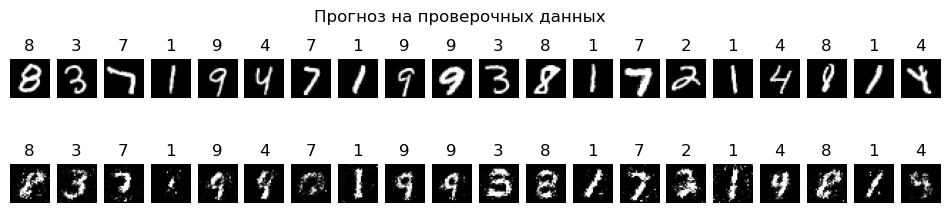

In [ ]:
# Функция для подготовки и обработки данных для тренировки
def m_inp(N):
    idx = np.random.randint(0, X_train.shape[0], N)  
    d_n = X_train[idx] 
    l_n = y_train[idx]  
    g_n_noise = np.random.normal(0, 1, (N, latent_dim))  
    return d_n, l_n, g_n_noise

# Загрузка сохраненной модели генератора
from keras.models import load_model
generator = load_model("/Users/lsh/Desktop/👩🏼‍💻/ВУЗ/5sem/Computer graphics/КГ 12 и 13/generator_model_4700.keras")

# Прогноз на проверочных данных
N = 20 
d_n, l_n, g_n_noise = m_inp(N)  
gen_imgs = generator.predict([g_n_noise, l_n])  

# Преобразуем пиксели изображений в диапазон [0, 1]
d_n = 0.5 * d_n + 0.5
gen_imgs = 0.5 * gen_imgs + 0.5

# Визуализация изображений: реальные и сгенерированные
fig, axs = plt.subplots(2, N, figsize = (12, 2.5))
fig.suptitle('Прогноз на проверочных данных')
for i in range(N): # Заголовок с меткой
    axs[0, i].imshow(d_n[i].reshape(28, 28), cmap = 'gray')  
    axs[1, i].title.set_text(l_n[i]) 
    axs[1, i].imshow(gen_imgs[i].reshape(28, 28), cmap = 'gray')  
    for k in range(2): axs[k, i].axis('off')  
plt.show() 
